## Modeling Notebook

### Baseline Models

In [5]:
# import data
import pandas as pd

data = pd.read_csv("data/cleaned_data_baseline.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Columns: 166 entries, application_order to father_job_Workers in food processing, woodworking, clothing and other industries and crafts
dtypes: float64(10), int64(156)
memory usage: 5.6 MB


### Preparing Data

In [6]:
X = data.drop(columns=["target"])
y = data["target"]

X.shape, y.shape

((4424, 165), (4424,))

In [7]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape

((3539, 165), (885, 165))

## Training Baseline Models

#### Decision Tree

In [8]:
from sklearn import tree

dt = tree.DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.6870056497175141

In [9]:
from sklearn import metrics

dt_predictions = dt.predict(X_test)
print({"Enrolled": 1, "Dropout": 0, "Graduate": 2})
metrics.confusion_matrix(y_test, dt_predictions, normalize="true")

{'Enrolled': 1, 'Dropout': 0, 'Graduate': 2}


array([[0.69303797, 0.17088608, 0.13607595],
       [0.25165563, 0.35761589, 0.39072848],
       [0.08133971, 0.11722488, 0.80143541]])

#### Naive Bayes

In [10]:
from sklearn import naive_bayes

naive_classifier = naive_bayes.GaussianNB()
naive_classifier.fit(X_train, y_train)
naive_classifier.score(X_test, y_test)

0.3638418079096045

In [11]:
naive_predictions = naive_classifier.predict(X_test)
metrics.confusion_matrix(y_test, naive_predictions)

array([[308,   6,   2],
       [139,  10,   2],
       [399,  15,   4]], dtype=int64)

#### XGBoost

In [12]:
from xgboost import XGBClassifier

xgboost_classifier = XGBClassifier(random_state=42)
xgboost_classifier.fit(X_train, y_train)
xgboost_classifier.score(X_test, y_test)

0.7638418079096045

In [13]:
xg_predictions = xgboost_classifier.predict(X_test)
metrics.confusion_matrix(y_test, xg_predictions)

array([[232,  39,  45],
       [ 35,  59,  57],
       [ 12,  21, 385]], dtype=int64)

## Baseline Models with Binary Classifier

The more advanced models tend to error on the side of missing those who actually do dropout.

In [14]:
y = y.map({2: 0, 1:0, 0:1})
y.value_counts()

target
0    3003
1    1421
Name: count, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape, X_test.shape

((3539, 165), (885, 165))

### Decision Tree

In [16]:
dt_binary = tree.DecisionTreeClassifier(random_state=42)
dt_binary.fit(X_train, y_train)
dt_binary.score(X_test, y_test)

0.7954802259887006

In [17]:
dt_binary_predictions = dt_binary.predict(X_test)
metrics.confusion_matrix(y_test, dt_binary_predictions)

array([[482,  87],
       [ 94, 222]], dtype=int64)

In [18]:
print(metrics.classification_report(y_test, dt_binary_predictions))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       569
           1       0.72      0.70      0.71       316

    accuracy                           0.80       885
   macro avg       0.78      0.77      0.78       885
weighted avg       0.79      0.80      0.79       885



### XGBoost

In [19]:
xgboost_binary = XGBClassifier(random_state=42)
xgboost_binary.fit(X_train, y_train)
xgboost_binary.score(X_test, y_test)

0.8508474576271187

In [20]:
xgboost_binary_predictions = xgboost_binary.predict(X_test)
metrics.confusion_matrix(y_test, xgboost_binary_predictions)

array([[527,  42],
       [ 90, 226]], dtype=int64)

In [24]:
print(metrics.classification_report(y_test, xgboost_binary_predictions))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89       569
           1       0.84      0.72      0.77       316

    accuracy                           0.85       885
   macro avg       0.85      0.82      0.83       885
weighted avg       0.85      0.85      0.85       885



### Random Forest

In [21]:
from sklearn import ensemble

rf_binary = ensemble.RandomForestClassifier(random_state=42)
rf_binary.fit(X_train, y_train)
rf_binary.score(X_test, y_test)

0.8531073446327684

In [22]:
rf_predictions = rf_binary.predict(X_test)
metrics.confusion_matrix(y_test, rf_predictions)

array([[538,  31],
       [ 99, 217]], dtype=int64)

In [25]:
print(metrics.classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89       569
           1       0.88      0.69      0.77       316

    accuracy                           0.85       885
   macro avg       0.86      0.82      0.83       885
weighted avg       0.86      0.85      0.85       885



### ROC Curves

In [38]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use([i for i in plt.style.available if "seaborn" in i][0])

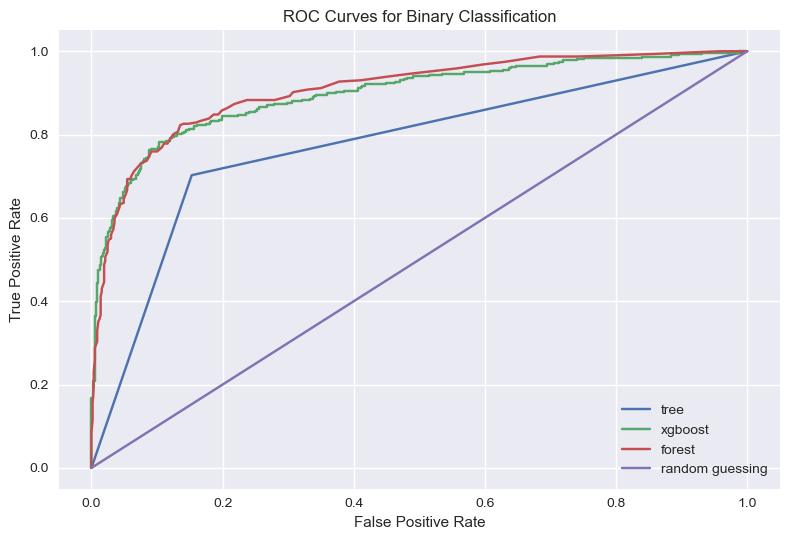

In [42]:
fig, ax = plt.subplots()

for name, model in [("tree", dt_binary), ("xgboost", xgboost_binary), ("forest", rf_binary)]:
    # get data for curve
    probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, probabilities)
    
    # plot curve
    ax.plot(fpr, tpr, label=name)
    
# some labels
ax.plot(np.linspace(0, 1), np.linspace(0, 1), label="random guessing")
ax.set_title("ROC Curves for Binary Classification")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend()
plt.tight_layout()